In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# source files
import sys
sys.path.append('scripts/')
from calibrated_regression import CalibratedRegression
from data_loader import load_quadratic_data

import pymc3 as pm

# plotting
import seaborn as sns
sns.set_style('white')
%matplotlib inline

(1250,) (250,) (1250,) (250,)


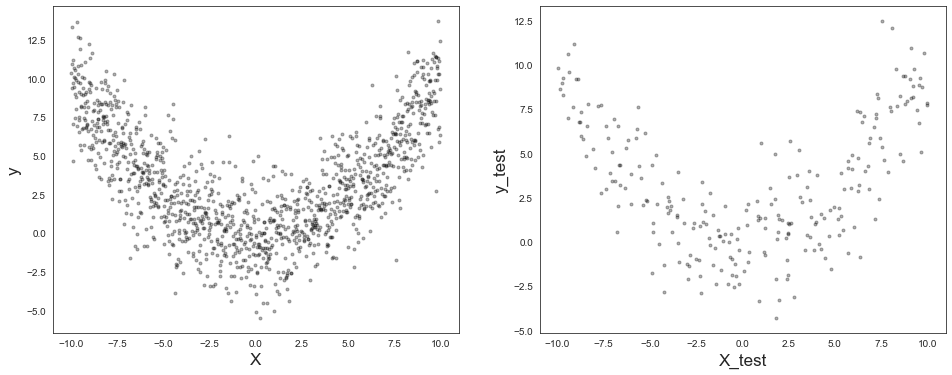

In [2]:
X, X_test, y, y_test = load_quadratic_data()
print(X.shape, X_test.shape, y.shape, y_test.shape)

# plotting X and y and X_test and y_test
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].plot(X, y, 'o', markersize=3, color='black', alpha=0.3)
ax[0].set_xlabel('X', fontsize=17)
ax[0].set_ylabel('y', fontsize=17)

ax[1].plot(X_test, y_test, 'o', markersize=3, color='black', alpha=0.3)
ax[1].set_xlabel('X_test', fontsize=17)
ax[1].set_ylabel('y_test', fontsize=17);

In [3]:
with pm.Model() as model:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f_x = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f_x, sigma=1, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, b, a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1751.61draws/s]
/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.100503,0.000947,0.000021,0.098652,0.102389,2056.668252,1.000553
b,0.003139,0.005000,0.000102,-0.006614,0.013105,2553.062046,1.001194
c,-0.069441,0.042657,0.001004,-0.155717,0.011307,1840.415820,1.001166


In [4]:
def posterior_predictive(x, a, b, c, sigma=1):
    '''Returns samples from posterior predictive.
    
    Parameters
    ----------
    x : array-like
        Data
    a : np.array
        Posterior samples of a
    b : np.array
        Posterior samples of b
    c : np.array
        Posterior samples of c
    sigma : float
        Standard deviation of observation noise
            
    Returns
    -------
    samples : np.array
    '''
    x, a, b, c = x.reshape(-1,1), a.reshape(-1,1), b.reshape(-1,1), c.reshape(-1,1)
    noise = np.random.normal(scale=sigma, size=a.shape[0])
    samples = (x**2).dot(a.T) + x.dot(b.T) + np.ones(x.shape).dot(c.T) + noise
    return samples

In [5]:
a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
pp_params = {'a': a, 'b': b, 'c': c}
calib = CalibratedRegression(X, y, model, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]
print(calib.predict_quantiles(quants))

,X,y,predicted_cdf,empirical_cdf
0,-3.408939,0.662968,0.351000,0.448
1,-1.420947,0.389131,0.609000,0.580
2,-1.967979,-2.471565,0.002667,0.068
3,-2.181454,0.996628,0.734000,0.652
4,8.585724,5.659071,0.045000,0.180


[3.00000000e-04 4.53333333e-01 9.99166667e-01]


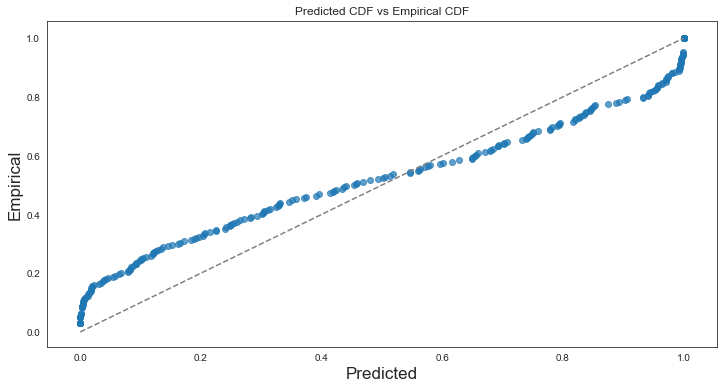

In [6]:
# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax)

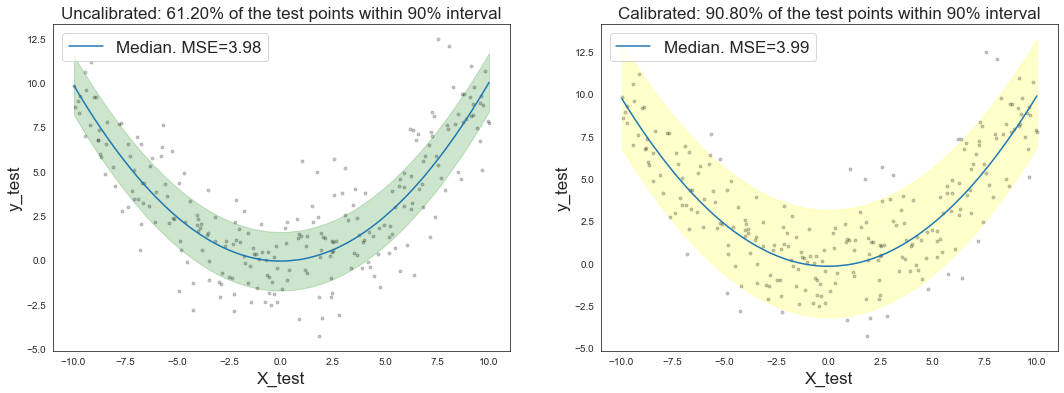

In [10]:
# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
calib.plot_intervals(ax, X_test, y_test, quantiles=[0.05, 0.5, 0.95]);

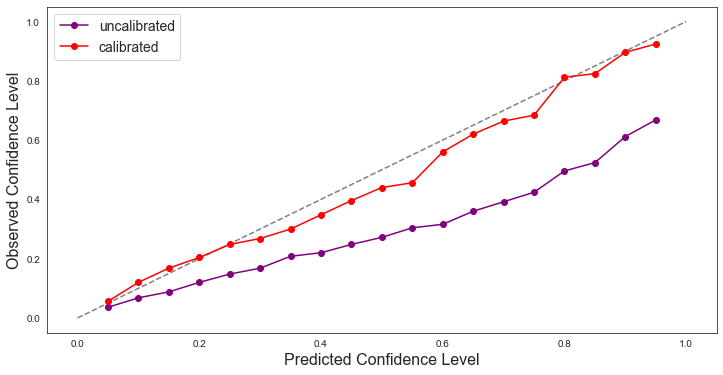

In [11]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

calib.plot_diagnostic_curve(ax, X_test, y_test);